# Replay and Fork an agent

## Build the agent

In [1]:
# Import libraries
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

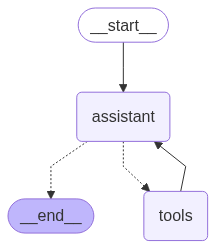

In [2]:
# Build agent

# Tool definitions

def multiply(a: int, b: int) -> int:
    """
        Function to multiply 2 given numbers
        The return value is an integer which is the product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """
        Function to add 2 given numbers
        The return value is an integer which is the sum of a and b
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
        Function to subtract 2 given numbers
        The return value is an integer which is the difference of a and b
    """
    return a - b

def divide(a: int, b: int) -> int:
    """
        Function to perform division on 2 given numbers
        The return value is an integer which is the quotient of a and b
    """
    return a / b

# Bind tools with Chat model
llm = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [multiply, add, subtract, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# Define LLM node
def assistant(state: MessagesState) -> MessagesState:
    systemMessage = [SystemMessage(content="You are a helpful assistant that can perform basic arithmetic operations.")]
    state["messages"] = llm_with_tools.invoke(systemMessage + state["messages"])
    return state

# Build Graph
memory = MemorySaver()
graphBuilder = StateGraph(MessagesState)
graphBuilder.add_node("assistant", assistant)
graphBuilder.add_node("tools", ToolNode(tools))

graphBuilder.add_edge(START, "assistant")
graphBuilder.add_conditional_edges("assistant", tools_condition)
graphBuilder.add_edge("tools", "assistant")

graph = graphBuilder.compile(checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Replay

In [3]:
# Execute the graph
initial_input = [HumanMessage(content="What is the product of 56 and 34?")]
thread = {"configurable": {"thread_id": 1}}

for event in graph.stream({"messages": initial_input}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the product of 56 and 34?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3PHnsjNRbX7JdBYTXASBTBTf)
 Call ID: call_3PHnsjNRbX7JdBYTXASBTBTf
  Args:
    a: 56
    b: 34
================================= Tool Message =================================
Name: multiply

1904
================================== Ai Message ==================================

The product of 56 and 34 is 1,904.


In [4]:
# Get current state
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3PHnsjNRbX7JdBYTXASBTBTf', 'function': {'arguments': '{"a":56,"b":34}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 212, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbyCrDG3SYlWweZPJNEOyZxeevvfH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--787b4c94-5a65-4a7e-85c9-0332478e4853-0', tool_calls=[{'name': 'multiply', 'args': {'a': 56, 'b': 34}

In [5]:
# Get state history
history = [ s for s in graph.get_state_history(thread)]
print("States:")
print(history)
print(f"Number of states: {len(history)}")

States:
[StateSnapshot(values={'messages': [HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3PHnsjNRbX7JdBYTXASBTBTf', 'function': {'arguments': '{"a":56,"b":34}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 212, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbyCrDG3SYlWweZPJNEOyZxeevvfH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--787b4c94-5a65-4a7e-85c9-0332478e4853-0', tool_calls=[{'name': 'multiply', 'args': {'a': 56,

In [6]:
# Select a state in history
to_replay = history[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b541-0cc4-6e80-8000-8d05e9fa9fb0'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': 1}, created_at='2025-05-27T23:41:09.360188+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b541-0cc3-6b34-bfff-09c3dd05e19d'}}, tasks=(PregelTask(id='61432d47-d116-915b-fa46-64bd4b666d29', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3PHnsjNRbX7JdBYTXASBTBTf', 'function': {'arguments': '{"a":56,"b":34}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage'

In [7]:
# Check history values, config and next node information
print("Selected node values:")
print(to_replay.values)
print("Selected node config:")
print(to_replay.config)
print("Next node of selected node:")
print(to_replay.next)

Selected node values:
{'messages': [HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8')]}
Selected node config:
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b541-0cc4-6e80-8000-8d05e9fa9fb0'}}
Next node of selected node:
('assistant',)


In [8]:
# Trigger replay
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the product of 56 and 34?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_eRTw3Ujhxe2UvAmk7wPywnnH)
 Call ID: call_eRTw3Ujhxe2UvAmk7wPywnnH
  Args:
    a: 56
    b: 34
================================= Tool Message =================================
Name: multiply

1904
================================== Ai Message ==================================

The product of 56 and 34 is 1904.


In [9]:
# Get state history after replay
history = [ s for s in graph.get_state_history(thread)]
print("States:")
print(history)
print(f"Number of states: {len(history)}")

States:
[StateSnapshot(values={'messages': [HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eRTw3Ujhxe2UvAmk7wPywnnH', 'function': {'arguments': '{"a":56,"b":34}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 212, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbyD5NoMCcUtb7yiCrRnOeWotAtZ9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09331abd-b8ca-4867-976c-8e5b263aebd7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 56,

## Forking

In [10]:
# Get message to fork
to_fork = history[-2]
to_fork.values["messages"]

[HumanMessage(content='What is the product of 56 and 34?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8')]

In [21]:
# View fork config
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b4f4-5397-6314-8000-df78f1aac30f'}}

In [11]:
# Create a forked checkpoint
forked_config = graph.update_state(to_fork.config, 
                                   {"messages": [HumanMessage(content="What is the sum of 10 and 5?",
                                                              id=to_fork.values["messages"][0].id)]})
forked_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03b545-e5d2-64d0-8001-f4603461a002'}}

In [12]:
# Get history after forking
history = [ s for s in graph.get_state_history(thread)]
history

[StateSnapshot(values={'messages': [HumanMessage(content='What is the sum of 10 and 5?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b545-e5d2-64d0-8001-f4603461a002'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='What is the sum of 10 and 5?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b541-0cc4-6e80-8000-8d05e9fa9fb0'}, created_at='2025-05-27T23:43:19.493946+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03b541-0cc4-6e80-8000-8d05e9fa9fb0'}}, tasks=(PregelTask(id='79bf3516-c4ce-8b0d-afa4-e437bbb42ecc', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=Non

In [13]:
# Run the graph from the created forked checkpoint
for event in graph.stream(None, forked_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the sum of 10 and 5?
================================== Ai Message ==================================
Tool Calls:
  add (call_Or1JNhw4RkhZ7GBgVKz83lqM)
 Call ID: call_Or1JNhw4RkhZ7GBgVKz83lqM
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================

The sum of 10 and 5 is 15.


In [15]:
# Check state
current_state = graph.get_state({'configurable': {'thread_id': '1'}})
current_state

StateSnapshot(values={'messages': [HumanMessage(content='What is the sum of 10 and 5?', additional_kwargs={}, response_metadata={}, id='8ebf2a0c-6ec7-4e81-8251-95eaf6a7a9f8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Or1JNhw4RkhZ7GBgVKz83lqM', 'function': {'arguments': '{"a":10,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 212, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbyF56vVM781k746w0aFhSucfTbFz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b0a6eaea-6cbb-45a9-8d43-211f655a38e9-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 5}, 'id': 'call_Or1

In [18]:
# Print messages in latest state
history = [s for s in graph.get_state_history(thread)]
for state in history:
    for m in state.values["messages"]:
        m.pretty_print()
    print("*" * 30)

================================ Human Message =================================

What is the sum of 10 and 5?
================================== Ai Message ==================================
Tool Calls:
  add (call_Or1JNhw4RkhZ7GBgVKz83lqM)
 Call ID: call_Or1JNhw4RkhZ7GBgVKz83lqM
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================

The sum of 10 and 5 is 15.
******************************
================================ Human Message =================================

What is the sum of 10 and 5?
================================== Ai Message ==================================
Tool Calls:
  add (call_Or1JNhw4RkhZ7GBgVKz83lqM)
 Call ID: call_Or1JNhw4RkhZ7GBgVKz83lqM
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15
******************************
=====================